In [1]:
#basic imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
train=pd.read_csv("train.csv",header=None,names=["text","emotion"],sep=";")
test=pd.read_csv("test.csv",header=None,names=["text","emotion"],sep=";")

In [3]:
train.head()

,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


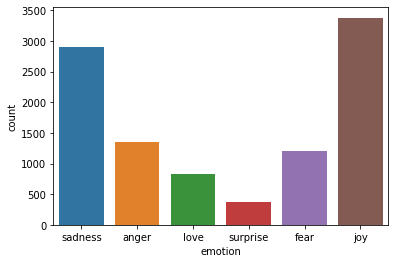

In [55]:
#Count plot of emotions 
sns.countplot(train.emotion)

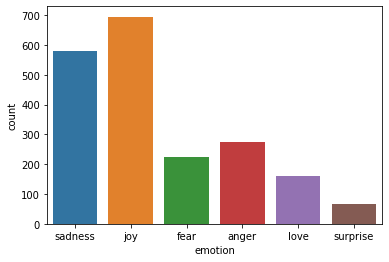

In [56]:
sns.countplot(test.emotion)

In [6]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
Lemmatizer=WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [7]:
corpus_train=[]
for i in range(len(train.text)):
    word=re.sub("[^a-zA-Z]"," ",train.text[i])
    word=word.lower()
    word=word.split()
    word=[Lemmatizer.lemmatize(words) for words in word if words not in set(stopwords.words("english"))]
    word=" ".join(word)
    corpus_train.append(word)

In [8]:
corpus_test=[]
for i in range(len(test.text)):
    word=re.sub("[^a-zA-Z]"," ",test.text[i])
    word=word.lower()
    word=word.split()
    word=[Lemmatizer.lemmatize(words) for words in word if words not in set(stopwords.words("english"))]
    word=" ".join(word)
    corpus_test.append(word)

In [9]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
encode=LabelEncoder()

In [17]:
label_train=encode.fit_transform(train.emotion)
label_test=encode.transform(test.emotion)

In [19]:
Y_test=to_categorical(label_test)
Y_train=to_categorical(label_train)

In [18]:
encode.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [21]:
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

Let's use tokenizer for our data

In [22]:
max_no = 50000
seq_len = 100
embed_dim = 100
tokenizer = Tokenizer(num_words=max_no, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train.text.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11999 unique tokens.


In [23]:
X = tokenizer.texts_to_sequences(train.text.values)
X_train = pad_sequences(X, maxlen=seq_len)

In [24]:
X=tokenizer.texts_to_sequences(test.text.values)
X_test = pad_sequences(X, maxlen=seq_len)

In [25]:
model = Sequential()
model.add(Embedding(max_no, embed_dim, input_length=X_train.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(100,activation="relu"))
model.add(Dense(6, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 128

model.fit(X_train,Y_train,epochs=epochs,batch_size=batch_size,validation_data=(X_test,Y_test),verbose=1)

Epoch 1/5
79/79 [==============================] - 37s 468ms/step - loss: 1.5943 - accuracy: 0.3414 - val_loss: 1.5269 - val_accuracy: 0.3475
Epoch 2/5
79/79 [==============================] - 37s 467ms/step - loss: 1.1837 - accuracy: 0.5483 - val_loss: 0.8082 - val_accuracy: 0.7220
Epoch 3/5
79/79 [==============================] - 37s 469ms/step - loss: 0.5238 - accuracy: 0.8132 - val_loss: 0.5256 - val_accuracy: 0.8145
Epoch 4/5
79/79 [==============================] - 38s 476ms/step - loss: 0.2624 - accuracy: 0.9149 - val_loss: 0.4298 - val_accuracy: 0.8570
Epoch 5/5
79/79 [==============================] - 37s 471ms/step - loss: 0.1408 - accuracy: 0.9562 - val_loss: 0.4132 - val_accuracy: 0.8685


In [26]:
model.fit(X_train,Y_train,epochs=10,batch_size=batch_size,validation_data=(X_test,Y_test),verbose=1,initial_epoch=5)

Epoch 6/10
79/79 [==============================] - 37s 471ms/step - loss: 0.0946 - accuracy: 0.9713 - val_loss: 0.4190 - val_accuracy: 0.8635
Epoch 7/10
79/79 [==============================] - 37s 472ms/step - loss: 0.0675 - accuracy: 0.9787 - val_loss: 0.4586 - val_accuracy: 0.8705
Epoch 8/10
79/79 [==============================] - 37s 468ms/step - loss: 0.0561 - accuracy: 0.9828 - val_loss: 0.4317 - val_accuracy: 0.8710
Epoch 9/10
79/79 [==============================] - 37s 469ms/step - loss: 0.0538 - accuracy: 0.9827 - val_loss: 0.4755 - val_accuracy: 0.8670
Epoch 10/10
79/79 [==============================] - 37s 472ms/step - loss: 0.0409 - accuracy: 0.9864 - val_loss: 0.4589 - val_accuracy: 0.8720


In [32]:
accuracy=model.history.history["accuracy"]
loss=model.history.history["loss"]
val_loss=model.history.history["val_loss"]
val_accuracy=model.history.history["val_accuracy"]

In [34]:
len(accuracy)

5

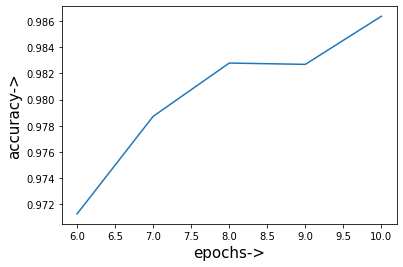

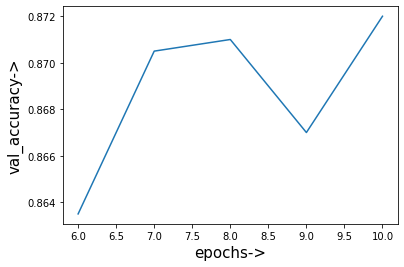

In [63]:
sns.lineplot(range(6,11),accuracy) #plotting of accuracy
plt.xlabel("epochs->",fontsize=15)
plt.ylabel("accuracy->",fontsize=15)
plt.show()
sns.lineplot(range(6,11),val_accuracy) #plotting of val_accuracy
plt.xlabel("epochs->",fontsize=15)
plt.ylabel("val_accuracy->",fontsize=15)
plt.show()

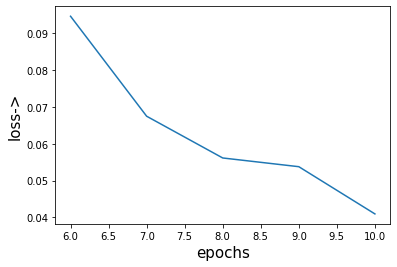

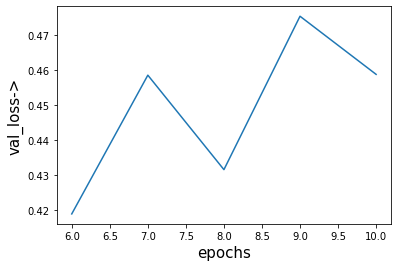

In [64]:
sns.lineplot(range(6,11),loss) #plotting of loss
plt.xlabel("epochs",fontsize=15)
plt.ylabel("loss->",fontsize=15)
plt.show()
sns.lineplot(range(6,11),val_loss)#plotting of val_loss
plt.xlabel("epochs",fontsize=15)
plt.ylabel("val_loss->",fontsize=15)
plt.show()

Text(0, 0.5, 'loss->')

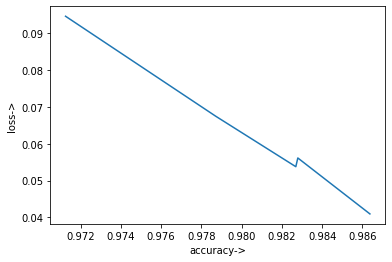

In [67]:
sns.lineplot(accuracy,loss)
plt.xlabel("accuracy->")
plt.ylabel("loss->")

In [47]:
pred=model.predict_classes(X_test)

In [ ]:
model.save("model.h5",save_format="h5")

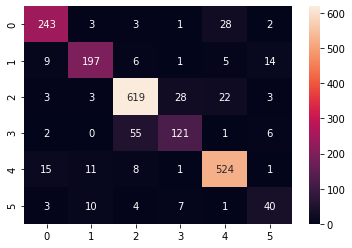

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(pred,label_test),annot=True,fmt="")

In [68]:
encode.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

In [69]:
#its better to store this dict
dict={'anger':0, 'fear':1, 'joy':2, 'love':3, 'sadness':4,'surprise':5}

In [46]:
len(pred)

2000

In [54]:
model.evaluate(X_test,Y_test)

63/63 [==============================] - 2s 27ms/step - loss: 0.4589 - accuracy: 0.8720


[0.4588783085346222, 0.871999979019165]

In [58]:
from sklearn.metrics import classification_report
print(classification_report(pred,label_test))

              precision    recall  f1-score   support

           0       0.88      0.87      0.88       280
           1       0.88      0.85      0.86       232
           2       0.89      0.91      0.90       678
           3       0.76      0.65      0.70       185
           4       0.90      0.94      0.92       560
           5       0.61      0.62      0.61        65

    accuracy                           0.87      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.87      0.87      0.87      2000

